<a href="https://colab.research.google.com/github/lookingglasslab/VisualFeatureSearch/blob/widen-support/notebooks/(2022)%20Interactive_Visual_Feature_Search_Interactive_Article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Visual Feature Search
## [Devon Ulrich](https://github.com/devonulrich) and [Ruth Fong](http://ruthfong.com/), [Princeton University](https://princeton.edu/)

**Note (12/2023): This interactive article is from 2022; we have since added new notebooks to our [Github repository](https://github.com/lookingglasslab/VisualFeatureSearch/tree/widen-support/notebooks) which are faster and easier to use than this notebook. We recommend new users to run and/or follow along with those notebooks first.**

This interactive article contains most qualitative visualizations from our [2022 preprint](https://arxiv.org/pdf/2211.15060.pdf). For more details, please see the paper. Our code is also released [here](https://github.com/lookingglasslab/VisualFeatureSearch).

We recommend you execute cell blocks sequentially one at a time. In particular, make sure to *download the ImageNet validation images* (see the next cell for instructions).

##  Download ImageNet validation images (**Action Required**)
We use a subset of the ImageNet validation set as our searchable database for visual feature search. To get the dataset:
1. Go to image-net.org and login or signup for access.
2. Go to the following URL: https://image-net.org/challenges/LSVRC/2012/2012-downloads.php
3. Copy the URL for downloading all validation images (with file size of 6.3Gb), and paste the URL below.
4. Run the script below to download the validation set and the ImageNet devkit in Colab.

In [ ]:
!wget [imagenet-url] # TODO: replace me
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz

## Other downloads and Python imports

In [2]:
!wget https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
!tar -xvf azcopy_linux_amd64_10.15.0.tar.gz

!pip install zarr

!./azcopy_linux_amd64_10.15.0/azcopy copy https://vissearch.blob.core.windows.net/data/ResNet_ImageNet_val.tar.gz ResNet_ImageNet_val.tar.gz
!tar -xzf ResNet_ImageNet_val.tar.gz

!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2023-12-15 08:27:05--  https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
Resolving azcopyvnext.azureedge.net (azcopyvnext.azureedge.net)... 72.21.81.200, 2606:2800:11f:17a5:191a:18d5:537:22f9
Connecting to azcopyvnext.azureedge.net (azcopyvnext.azureedge.net)|72.21.81.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12512512 (12M) [application/gzip]
Saving to: ‘azcopy_linux_amd64_10.15.0.tar.gz’

azcopy_linux_amd64_ 100%[===================>]  11.93M  --.-KB/s    in 0.07s   

2023-12-15 08:27:05 (168 MB/s) - ‘azcopy_linux_amd64_10.15.0.tar.gz’ saved [12512512/12512512]

azcopy_linux_amd64_10.15.0/
azcopy_linux_amd64_10.15.0/azcopy
azcopy_linux_amd64_10.15.0/NOTICE.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-

In [3]:
# TODO: change to regular pip upon release
!pip install -i https://test.pypi.org/simple/ --no-deps visualfeaturesearch==0.0.11

Looking in indexes: https://test.pypi.org/simple/


In [4]:
import sys
import os
import numpy as np
import requests
from PIL import Image
import ast
from textwrap import wrap
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import zarr

import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool, get_crop_rect

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

sv_inet_model = torchvision.models.resnet50(pretrained=True)
sv_inet_model = sv_inet_model.cuda().eval()

sv_inet_conv5 = vfs.util.FeatureHook(sv_inet_model, sv_inet_model.layer4[2].conv2)

CONV5_FEATURE_SIZE = 7 # row/column length for the layer of interest

# set up dataset
imagenet_dataset = torchvision.datasets.ImageNet('./', 'val', transform=vfs.data.net_transform)
vis_imagenet_dataset = torchvision.datasets.ImageNet('./', 'val', transform=vfs.data.vis_transform)
!rm ILSVRC2012_img_val.tar

with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
  imagenet_labels = ast.literal_eval(f.read())

# set up cached search tool
sv_inet_store = zarr.DirectoryStore('ResNet_ImageNet_val')
sv_inet_root = zarr.group(store=sv_inet_store, overwrite=False)
sv_inet_conv5_data = sv_inet_root['conv5']

cached_search_tool = CachedSearchTool(sv_inet_conv5, sv_inet_conv5_data, device, batch_size=5000)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


## Motivation

In the past decade, the field of interpretability has focused on developing a variety of tools for understanding the behavior of convolutional neural networks (CNNs). Much of this work has been on developing *static* visualizations that elucidate an aspect of a model. For instance, *attribution heatmaps* aim to highlight the image regions that are most responsible for a model's output decision, while *feature visualizations* aim to visualize an internal component of a model (e.g. the patterns that most activate a specific CNN channel).

However, static visualizations do not utilize the full expressive power of modern web technologies. We argue that well-designed *interactive visualizations* are useful for allowing machine learning (ML) researchers to quickly easily explore models.
Currently, most interactive visualizations are specific to a limited set of models (i.e. they are more like to well-polished demos) but are not easily extendable to novel models. This aspect limits their ability to be used by researchers in their regular workflow for understanding their own, custom models.

## Visual Feature Search
*This section corresponds to Section 3 in our full paper.*

We introduce a novel interactive visualization tool, Visual Feature Search, that allows users to easily and quickly perform a "reverse search" using CNN features.

The main steps of our tool are as follows:

1. A user selects the model, layer, and dataset they want to explore.
2. A user highlights a free-form region in an query image using our interactive highlighting widget.
2. Our tool searches through a datset of images for other image regions that have the most similar CNN features to the highlighted region.
3. Our tool retrieves and shows the most similar image regions.

## Basic Example
*This example corresponds with Figures 1 and 2 in our full paper.*

First, select the image you'd like to visualize and then hold down your mouse click and highlight the region you'd like to search for similarly encoded regions.

To reproduce Fig. 1, select the first dog image and highlight its face. To reproduce Fig. 2, select the second church image and highlight its tower.

In [5]:
# download ten query images to use
query_img_ids = ["004", "530", "495", "211", "652", "021", "686", "016", "713", "198"]

def load_img(idx: str):
  url = "https://vissearch.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000" + idx + ".JPEG"
  img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
  return img

query_model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

query_imgs = [load_img(id) for id in query_img_ids]
vis_query_imgs = [vfs.data.vis_transform(img) for img in query_imgs]
model_query_imgs = [vfs.data.net_transform(img) for img in query_imgs]

# convert images to Data URLs so we can pass them into the HTML widget
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_query_imgs]

highlight_data = None
highlight_index = None
def highlight_callback(data):
    global highlight_data, highlight_index
    if isinstance(data, str): # the data get returned in different formats for Colab and Jupyter notebook
        data = data.rsplit(',', 1)
    highlight_data = data[0]
    highlight_index = int(data[1])
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

Next, we search for the most similar image regions, as encoded by an ImageNet-trained ResNet50 in the 5th convolutional block (see "Experimental Details" for more on layer selection).

In [6]:
assert highlight_data is not None, "Use the widget to highlight an image region"

selected_idx = int(highlight_index)
mask = vfs.util.durl_to_image(highlight_data)

cached_search_tool.set_input_image(model_query_imgs[selected_idx])

conv5_transform = transforms.Resize(7)
conv5_mask = conv5_transform(mask)
conv5_mask_arr = np.asarray(conv5_mask)[:,:,3] / 255

print('Loading results...')
conv5_sims, conv5_xs, conv5_ys = cached_search_tool.compute(conv5_mask_arr)
conv5_order = torch.argsort(conv5_sims, descending=True)
print('Done.')

Loading results...
Done.


Now, we show the top 5 most similar image regions and show their cosine similarity score to the highlighted region in the query image.

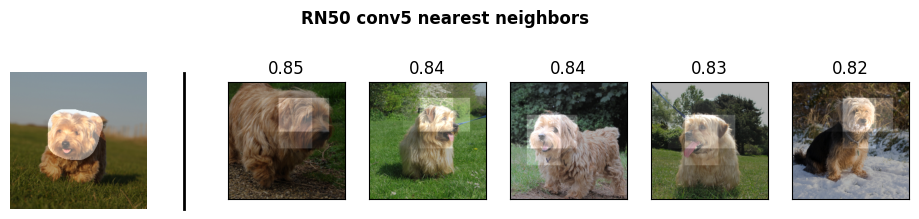

In [7]:
# visualize results
# set up the figure
DISPLAY_NUM = 5

fig = plt.figure(figsize=(11.6, 5.15), dpi=100)
fig.suptitle('RN50 conv5 nearest neighbors', fontweight='bold', y=0.75)
gs = fig.add_gridspec(1,2, width_ratios=[1,5])
results_gs = gs[1].subgridspec(1,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_query_imgs[selected_idx], 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
ax.add_line(matplotlib.lines.Line2D([285,285], [0,224], lw=2, color='black')).set_clip_on(False)

for i in range(DISPLAY_NUM):
  idx = conv5_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   x=conv5_xs[idx],
                                   y=conv5_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{conv5_sims[idx].cpu().numpy():.02f}')

## Experimental details

Unless otherwise specified, we visualize **ResNet50 models**.
Typically, works study the features immediately after a major convolutional block.
However, we study the features from the **second to last convolutional layer** within these blocks.

For instance, instead of extracting features from conv4, block 6, layer 3 (i.e. `layer3.5.2` in [torchvision](https://github.com/pytorch/vision)'s ResNet50), we extract features from conv4, block 6, layer 2 (i.e. `layer3.5.1`).

This is because features after the conv4 block are 4x larger than the features after the penultimate layer in the conv4 block (i.e. storing uncompressed, conv4-block features for 50k images require $\approx$ 70GB), and we choose to make our experiments more portable and available on low-memory environments like Google Colab.

For brevity, we refer to the features after the second convolutional in each residual block by their "convX" group (i.e. "conv4" in this notebook refers to conv4, block 6, layer 2, a.k.a. `layer3.5.1` in torchvision's ResNet50).

## In- vs. Out-of-Domain Images
*This section corresponds to Section 4.1 in our full paper and reproduces rows a-c in Figure 3.*

One potential use of our tool is to understand how robust a model is when presented with novel images. In this example, we visualize a ResNet50 model trained on ImageNet for several different query images:
1. In-domain images from the ImageNet test set
2. Out-of-domain images from ImageNet-A ([Hendricks et al., CVPR 2021](https://github.com/hendrycks/natural-adv-examples))
3. Out-of-domain images from ImageNet-Sketch ([Wang et al., NeurIPS 2019](https://github.com/HaohanWang/ImageNet-Sketch))

First, download the ImageNet-A and ImageNet-Sketch datasets.

In [ ]:
# Download ImageNet-A
!wget https://people.eecs.berkeley.edu/~hendrycks/imagenet-a.tar
!tar -xf imagenet-a.tar
!rm imagenet-a/README.txt

# Download ImageNet-Sketch
!wget https://huggingface.co/datasets/imagenet_sketch/resolve/main/data/ImageNet-Sketch.zip
!unzip ImageNet-Sketch.zip

!rm ImageNet-Sketch.zip
!rm imagenet-a.tar

Next, we show the three query images with the same ImageNet class (i.e. images of mosques) from each of the respective datasets (ImageNet, ImageNet-A, and ImageNet-Sketch).

Text(0.5, 1.0, 'ImageNet-Sketch')

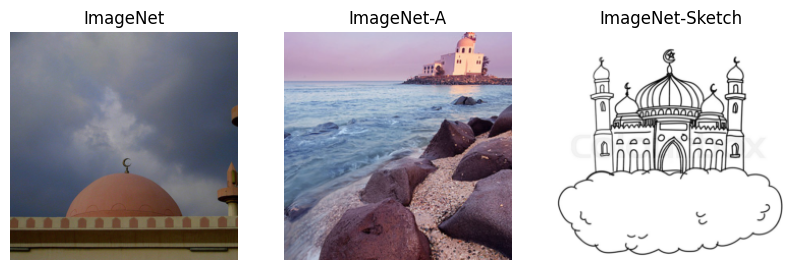

In [9]:
inet_path = 'val/n03788195/ILSVRC2012_val_00026188.JPEG'
inet_a_path = 'imagenet-a/n03788195/0.000251_stingray _ stingray_0.7409649.jpg'
sketch_path = 'sketch/n03788195/sketch_26.JPEG'

inet_img = Image.open(inet_path).convert('RGB')
inet_a_img = Image.open(inet_a_path).convert('RGB')
sketch_img = Image.open(sketch_path).convert('RGB')

vis_inet_img = vfs.data.vis_transform(inet_img)
vis_inet_a_img = vfs.data.vis_transform(inet_a_img)
vis_sketch_img = vfs.data.vis_transform(sketch_img)

cnn_inet_img = vfs.data.net_transform(inet_img)
cnn_inet_a_img = vfs.data.net_transform(inet_a_img)
cnn_sketch_img = vfs.data.net_transform(sketch_img)

# visualize the three images
plt.subplot(1,3,1)
plt.imshow(vis_inet_img, cmap='gray')
plt.axis('off')
plt.title('ImageNet')
plt.subplot(1,3,2)
plt.imshow(vis_inet_a_img, cmap='gray')
plt.axis('off')
plt.title('ImageNet-A')
plt.subplot(1,3,3)
plt.imshow(vis_sketch_img, cmap='gray')
plt.axis('off')
plt.title('ImageNet-Sketch')

Then, we highlight the same canonical part in each query image (i.e. the dome on a mosque).

*See Fig. 3 for query image regions to reproduce the figure.*

In [10]:
inet_callback_data = None
def inet_highlight(data):
    global inet_callback_data
    inet_callback_data = data
vfs.util.create_callback('inet_highlight', inet_highlight)

print('ImageNet Mosque:')
vfs.widgets.HighlightWidget(vfs.util.image_to_durl(vis_inet_img), callback_name='inet_highlight')

ImageNet Mosque:


In [11]:
inet_a_callback_data = None
def inet_a_highlight(data):
    global inet_a_callback_data
    inet_a_callback_data = data
vfs.util.create_callback('inet_a_highlight', inet_a_highlight)

print("ImageNet-A Mosque:")
vfs.widgets.HighlightWidget(vfs.util.image_to_durl(vis_inet_a_img), callback_name='inet_a_highlight')

ImageNet-A Mosque:


In [12]:
sketch_callback_data = None
def sketch_highlight(data):
    global sketch_callback_data
    sketch_callback_data = data
vfs.util.create_callback('sketch_highlight', sketch_highlight)

print("ImageNet-Sketch Mosque:")
vfs.widgets.HighlightWidget(vfs.util.image_to_durl(vis_sketch_img), callback_name='sketch_highlight')

ImageNet-Sketch Mosque:


We then search for the most similar regions as encoded in a ResNet50 conv5 features for each of the highlighted regions from the query images.

In [13]:
assert inet_callback_data is not None, "1st widget needs a highlighted region"
assert inet_a_callback_data is not None, "2nd widget needs a highlighted region"
assert sketch_callback_data is not None, "3rd widget needs a highlighted region"

conv5_transform = transforms.Resize(CONV5_FEATURE_SIZE)

# assemble masks
inet_mask = vfs.util.durl_to_image(inet_callback_data)
inet_mask_small = conv5_transform(inet_mask)
inet_mask_arr = np.asarray(inet_mask_small)[:,:,3] / 255

inet_a_mask = vfs.util.durl_to_image(inet_a_callback_data)
inet_a_mask_small = conv5_transform(inet_a_mask)
inet_a_mask_arr = np.asarray(inet_a_mask_small)[:,:,3] / 255

sketch_mask = vfs.util.durl_to_image(sketch_callback_data)
sketch_mask_small = conv5_transform(sketch_mask)
sketch_mask_arr = np.asarray(sketch_mask_small)[:,:,3] / 255

# compute the similarities
print('Loading Results...')

# ImageNet
cached_search_tool.set_input_image(cnn_inet_img)
inet_sims, inet_xs, inet_ys = cached_search_tool.compute(inet_mask_arr)
inet_order = torch.argsort(inet_sims, descending=True)

# ImageNet-A
cached_search_tool.set_input_image(cnn_inet_a_img)
inet_a_sims, inet_a_xs, inet_a_ys = cached_search_tool.compute(inet_a_mask_arr)
inet_a_order = torch.argsort(inet_a_sims, descending=True)

# ImageNet-Sketch
cached_search_tool.set_input_image(cnn_sketch_img)
sketch_sims, sketch_xs, sketch_ys = cached_search_tool.compute(sketch_mask_arr)
sketch_order = torch.argsort(sketch_sims, descending=True)

print('Done.')

Loading Results...
Done.


Finally, we show the most similar regions to each of the 3 query images.

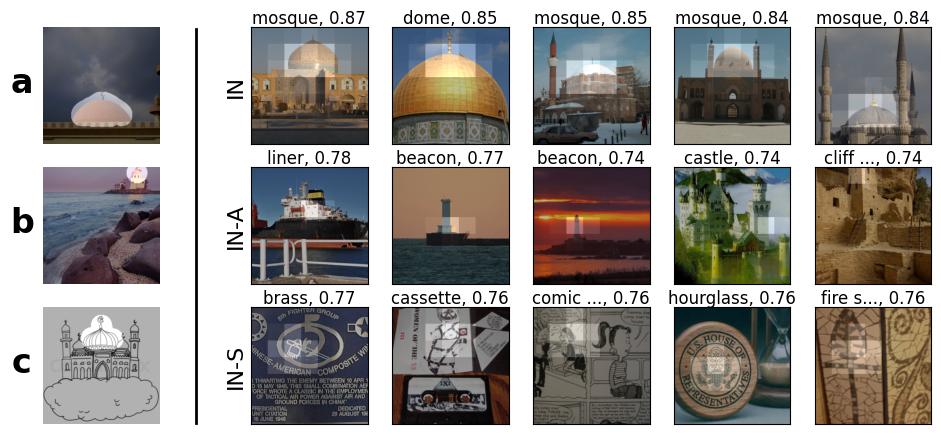

In [14]:
# set up the figure
DISPLAY_NUM = 5
TEXT_CUTOFF = 6

toTensor = transforms.ToTensor()

fig = plt.figure(figsize=(11.6, 5.15), dpi=100)
gs = fig.add_gridspec(1,2, width_ratios=[1,5])
queries_gs = gs[0].subgridspec(3,1)
results_gs = gs[1].subgridspec(3,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(queries_gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_inet_img, 0, 0, 224, np.asarray(inet_mask)[:,:,3] / 256))
ax.text(-40, 124, 'a', weight='bold', size=24, horizontalalignment='center')

ax = fig.add_subplot(queries_gs[1])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_inet_a_img, 0, 0, 224, np.asarray(inet_a_mask)[:,:,3] / 256))
ax.text(-40, 124, 'b', weight='bold', size=24, horizontalalignment='center')
ax.add_line(matplotlib.lines.Line2D([295,295], [-267,224+267], lw=2, color='black')).set_clip_on(False)

ax = fig.add_subplot(queries_gs[2])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_sketch_img, 0, 0, 224, np.asarray(sketch_mask)[:,:,3] / 256))
ax.text(-40, 124, 'c', weight='bold', size=24, horizontalalignment='center')

for i in range(DISPLAY_NUM):
  # imagenet
  idx = inet_order[i+1] # ignore first result, which will be the query image
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   inet_xs[idx],
                                   inet_ys[idx],
                                   7,
                                   vfs.util.crop_mask(inet_mask_arr))

  ax = fig.add_subplot(results_gs[0,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel

  gt_label = imagenet_labels[int(idx) // 50].split(',')[0]
  if len(gt_label) > TEXT_CUTOFF+3:
    gt_label = gt_label[:TEXT_CUTOFF] + '...'
  sim_str = str(np.round(inet_sims[idx].cpu().numpy(), 2))
  new_title = gt_label + ', ' + sim_str
  ax.set_title(new_title, fontsize=12, pad=2)
  if i==0:
    ax.set_ylabel('IN', fontsize=16)

  # imagenet-a
  idx = inet_a_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   inet_a_xs[idx],
                                   inet_a_ys[idx],
                                   7,
                                   vfs.util.crop_mask(inet_a_mask_arr))

  ax = fig.add_subplot(results_gs[1,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel

  gt_label = imagenet_labels[int(idx) // 50].split(',')[0]
  if len(gt_label) > TEXT_CUTOFF+3:
    gt_label = gt_label[:TEXT_CUTOFF] + '...'
  sim_str = str(np.round(inet_a_sims[idx].cpu().numpy(), 2))
  new_title = gt_label + ', ' + sim_str
  ax.set_title(new_title, fontsize=12, pad=2)
  if i==0:
    ax.set_ylabel('IN-A', fontsize=16)

  # imagenet-sketch
  idx = sketch_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   sketch_xs[idx],
                                   sketch_ys[idx],
                                   7,
                                   vfs.util.crop_mask(sketch_mask_arr))


  ax = fig.add_subplot(results_gs[2,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel

  gt_label = imagenet_labels[int(idx) // 50].split(',')[0]
  if len(gt_label) > TEXT_CUTOFF+3:
    gt_label = gt_label[:TEXT_CUTOFF] + '...'
  sim_str = str(np.round(sketch_sims[idx].cpu().numpy(), 2))
  new_title = gt_label + ', ' + sim_str
  ax.set_title(new_title, fontsize=12, pad=2)
  if i==0:
    ax.set_ylabel('IN-S', fontsize=16)

The visualization above shows that the out-of-domain images (rows **b** and **c**) have lower cosine similarity scores than those of the in-domain images (row **a**), and they often possess a different ground-truth label than that of the query image. For instance, notice how the mosque ImageNet-Sketch results (row **c**) shows nearest neighbors that are other illustrations, rather than other mosque buildings.

## Supervised vs. Self-Supervised Models
*This section corresponds to Section 4.3 in our full paper and reproduces row a in Figure 4.*

Another use case of our tool is to understand how different training paradigms influence a model's feature representation.
For instance, much work in the past decade has focused on self-supervised learning, which aims to learn useful, general features without labels (in contrast to supervised learning, which requires labels for training).
These approaches have steadily competed and now (as of 2020) surpass performance of supervised, ImageNet-trained models on certain tasks, when extremely large datasets of images are used for self-supervised training.

In this example, we visualize representations of ResNet50 models trained on ImageNet using SimCLR self-supervision ([Chen et al., ICML 2020](https://github.com/google-research/simclr)) vs. standard full-supervision. In particular, we show results for the following three layers:
1. SimCLR conv5
2. Supervised conv4
3. Supervised conv5

We first download the activation caches for SimCLR- and ImageNet-trained ResNet50 models.

In [ ]:
# free up space for new cache files
!rm -rf sketch
!rm -rf imagenet-a
!rm -rf ResNet_ImageNet_val

!./azcopy_linux_amd64_10.15.0/azcopy copy "https://vissearch.blob.core.windows.net/data/ResNet_IN_6_20.tar.gz" "ResNet_IN_6_20.tar.gz"
!tar -xzf ResNet_IN_6_20.tar.gz
!rm ResNet_IN_6_20.tar.gz

!./azcopy_linux_amd64_10.15.0/azcopy copy "https://vissearch.blob.core.windows.net/data/SimCLR_IN_6_20.tar.gz" "SimCLR_IN_6_20.tar.gz"
!tar -xzf SimCLR_IN_6_20.tar.gz
!rm SimCLR_IN_6_20.tar.gz

!pip install lightning-bolts

Then, we set-up our search tool to explore SimCLR conv5 and supervised conv4 and conv5.

In [ ]:
from pl_bolts.models.self_supervised import SimCLR

simclr_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset_simclr = torchvision.datasets.ImageNet('./', 'val', transform=simclr_transform)

weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
simclr_model = SimCLR.load_from_checkpoint(weight_path, strict=False)
simclr_model = simclr_model.encoder
simclr_model = simclr_model.cuda().eval()

simclr_inet_conv5 = vfs.util.FeatureHook(simclr_model, simclr_model.layer4[2].conv2)
sv_inet_conv4 = vfs.util.FeatureHook(sv_inet_model, sv_inet_model.layer3[5].conv2)

supervised_store = zarr.DirectoryStore('ResNet_IN_6_20')
supervised_root = zarr.group(store=supervised_store, overwrite=False)
sv_conv4_arr = supervised_root['conv4']
sv_conv5_arr = supervised_root['conv5']

sv_conv4_st = CachedSearchTool(sv_inet_conv4, sv_conv4_arr, device, batch_size=5000)
sv_conv5_st = CachedSearchTool(sv_inet_conv5, sv_conv5_arr, device, batch_size=5000)

simclr_store = zarr.DirectoryStore('SimCLR_IN_6_20')
simclr_root = zarr.group(store=simclr_store, overwrite=False)
simclr_arr = simclr_root['conv5']

simclr_conv5_st = CachedSearchTool(simclr_inet_conv5, simclr_arr, device, batch_size=5000)

Next, we select a region in the image. To reproduce Fig. 4 row a, select the entire neck of the bird (see Fig. 4).

In [17]:
url = 'https://vissearch.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000652.JPEG'
query_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
vis_query_img = vfs.data.vis_transform(query_img)
simclr_query_img = simclr_transform(query_img)
sv_query_img = vfs.data.net_transform(query_img)

# convert images to Data URLs so we can pass them into the HTML widget
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_query_imgs]
query_url = vfs.util.image_to_durl(vis_query_img)

highlight_data = None
def highlight_callback(data):
    global highlight_data
    highlight_data = data
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.HighlightWidget(img_url=query_url, callback_name='highlight_callback')

We then search through activations for the nearest neighbors in SimCLR conv5, supervised conv5, and supervised conv4.

In [18]:
assert highlight_data is not None, "Use the widget to highlight an image region"

mask = vfs.util.durl_to_image(highlight_data)

sv_conv4_st.set_input_image(sv_query_img)
sv_conv5_st.set_input_image(sv_query_img)
simclr_conv5_st.set_input_image(simclr_query_img)

conv4_transform = transforms.Resize(14)
conv4_mask = conv4_transform(mask)
conv4_mask_arr = np.asarray(conv4_mask)[:,:,3] / 255

conv5_transform = transforms.Resize(7)
conv5_mask = conv5_transform(mask)
conv5_mask_arr = np.asarray(conv5_mask)[:,:,3] / 255

print('Loading results...')
sv4_sims, sv4_xs, sv4_ys = sv_conv4_st.compute(conv4_mask_arr)
sv5_sims, sv5_xs, sv5_ys = sv_conv5_st.compute(conv5_mask_arr)
clr_sims, clr_xs, clr_ys = simclr_conv5_st.compute(conv5_mask_arr)

sv4_order = torch.argsort(sv4_sims, descending=True)
sv5_order = torch.argsort(sv5_sims, descending=True)
clr_order = torch.argsort(clr_sims, descending=True)
print('Done.')

Loading results...
Done.


Finally, we show the top-5 nearest neighbors for each of the layers (CLR-5 denotes SimCLR conv5, while SV-4 and SV-5 denote supervised conv4 and supervised conv5 respectively).

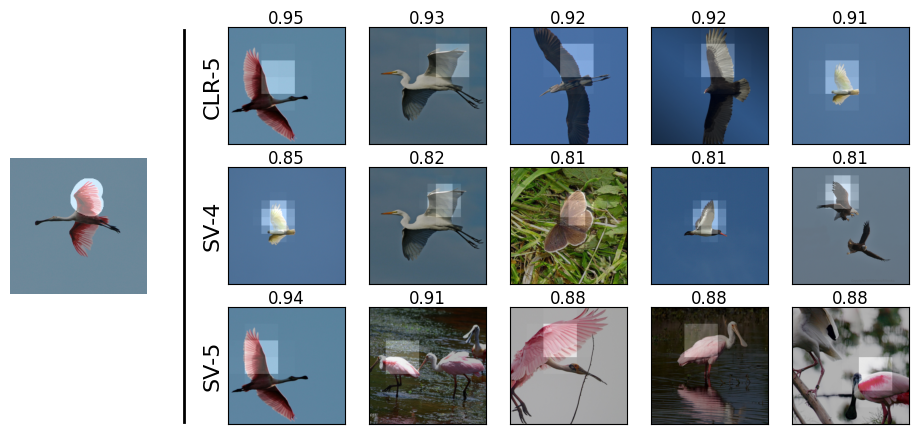

In [19]:
# visualize results
DISPLAY_NUM = 5

fig = plt.figure(figsize=(11.6, 5.15), dpi=100)
gs = fig.add_gridspec(1,2, width_ratios=[1,5])
results_gs = gs[1].subgridspec(3,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_query_img, 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
ax.add_line(matplotlib.lines.Line2D([285,285], [-210,224+210], lw=2, color='black')).set_clip_on(False)


for i in range(DISPLAY_NUM):
  # handle SimCLR features
  idx = clr_order[i]
  curr_img_out = vfs.util.mask_overlay(dataset_simclr[idx][0].permute(1,2,0) * 256,
                                   x=clr_xs[idx],
                                   y=clr_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[0,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel
  ax.set_title( f'{clr_sims[idx].cpu().numpy():.02f}', pad=0)
  if i == 0:
   ax.set_ylabel('CLR-5', fontsize=16)

  # now do the same for sv-conv4 features
  idx = sv4_order[i]
  curr_img_out = vfs.util.mask_overlay(dataset_simclr[idx][0].permute(1,2,0) * 256,
                                   x=sv4_xs[idx],
                                   y=sv4_ys[idx],
                                   mask_size=14,
                                   mask=vfs.util.crop_mask(conv4_mask_arr))

  ax = fig.add_subplot(results_gs[1,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{sv4_sims[idx].cpu().numpy():.02f}', pad=0)
  if i == 0:
   ax.set_ylabel('SV-4', fontsize=16)

  # finally display sv-conv5 features
  idx = sv5_order[i]
  curr_img_out = vfs.util.mask_overlay(dataset_simclr[idx][0].permute(1,2,0) * 256,
                                   x=sv5_xs[idx],
                                   y=sv5_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[2,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{sv5_sims[idx].cpu().numpy():.02f}', pad=0)
  if i == 0:
   ax.set_ylabel('SV-5', fontsize=16)

If Fig. 5, row a, was reproduced, notice how SimCLR conv5's nearest neighbors highlighted the necks of other bird species, while supervised conv5 tended to highlight other birds from the same species, and supervised conv4 appears to show results in between the two other layers.

Qualitative visualizations like this one led us to believe that SimCLR conv4 was more representationally similar to supervised conv4 than supervised conv5. Thus, we quantitatively analyzed the similarities between the three layers in our full paper and found that, actually, SimCLR conv5 was more similar to supervised conv5 than supervised conv4 (see full paper for more details).
This highlights an important limitation of our work, namely, that qualitative visualizations can help someone develop hypotheses about a model's behavior but that any hypotheses must be quantitatively validated.

## ImageNet vs. PASS Pretraining

*This section corresponds to Section 4.4 in our full paper and reproduces row a in Figure 7.*

A third use case of our tool is to study how the choice of training dataset affects a model's features.
To mitigate privacy concerns of training on images with humans, the PASS dataset ([Asano et al., NeurIPS Datasets 2021](https://www.robots.ox.ac.uk/~vgg/data/pass/)) was recently introduced as an ImageNet replacement for self-supervised learning.
PASS is a large dataset of unlabelled images that does not contain human faces or body parts and has been shown to perform as well as ImageNet-trained models on human-centric tasks (i.e. pose estimation).

In this example, we visualize two ResNet50 models trained via MOCO-v2 self-supervision using two different training datasets:
1. PASS
2. ImageNet

Because we are particularly interested in how the two models compare in their ability to represent faces, we visualize results for query images containing human faces.

First, we download new activation cache files for PASS- and ImageNet-trained models.

In [20]:
# free up space for new cache file
!rm -rf ResNet_IN_6_20
!rm -rf SimCLR_IN_6_20

!wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar

# feature caches
!./azcopy_linux_amd64_10.15.0/azcopy copy "https://vissearch.blob.core.windows.net/data/PASS_MoCo_6_20.tar.gz" "PASS_MoCo_6_20.tar.gz"
!tar -xzf PASS_MoCo_6_20.tar.gz
!./azcopy_linux_amd64_10.15.0/azcopy copy "https://vissearch.blob.core.windows.net/data/ImageNet_MoCo_6_20.tar.gz" "ImageNet_MoCo_6_20.tar.gz"
!tar -xzf ImageNet_MoCo_6_20.tar.gz

!rm PASS_MoCo_6_20.tar.gz
!rm ImageNet_MoCo_6_20.tar.gz

--2023-12-15 09:00:16--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112133139 (107M) [application/octet-stream]
Saving to: ‘moco_v2_800ep_pretrain.pth.tar’

moco_v2_800ep_pretr 100%[===================>] 106.94M   137MB/s    in 0.8s    

2023-12-15 09:00:17 (137 MB/s) - ‘moco_v2_800ep_pretrain.pth.tar’ saved [112133139/112133139]

INFO: Scanning...
INFO: azcopy: A newer version 10.22.0 is available to download

INFO: Any empty folders will not be processed, because source and/or destination doesn't have full folder support

Job 785c64cc-f2c0-f341-7c06-e65b81edf22d has started
Log file is located at: /root/.azcopy/785c64cc-f2c0-f341-7c06-e65b81edf22d.log

100.0 %, 1 Done, 0 Failed

Then, we set up our search tool to search through activations in the two models (e.g. PASS- and ImageNet-trained ResNet50 models trained via MOCO-v2).

In [21]:
imagenet_moco = torchvision.models.resnet50()
checkpoint = torch.load('moco_v2_800ep_pretrain.pth.tar')
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
        # remove prefix
        state_dict[k[len("module.encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]

msg = imagenet_moco.load_state_dict(state_dict, strict=False)
assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}

imagenet_moco = imagenet_moco.eval().cuda()

# load PASS MoCo
pass_moco = torch.hub.load('yukimasano/PASS:main', 'moco_resnet50')
pass_moco = pass_moco.eval().cuda()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/yukimasano/PASS/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packa

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias'])


In [22]:
# model dissection methods

moco_inet_conv5 = vfs.util.FeatureHook(imagenet_moco, imagenet_moco.layer4[2].conv2)
moco_pass_conv5 = vfs.util.FeatureHook(pass_moco, pass_moco.layer4[2].conv2)

inet_store = zarr.DirectoryStore('ImageNet_MoCo_6_20')
supervised_root = zarr.group(store=inet_store, overwrite=False)
inet_conv5_arr = supervised_root['conv5']

inet_moco_st = CachedSearchTool(moco_inet_conv5, inet_conv5_arr, device, batch_size=5000)

pass_store = zarr.DirectoryStore('PASS_MoCo_6_20')
supervised_root = zarr.group(store=pass_store, overwrite=False)
pass_conv5_arr = supervised_root['conv5']

pass_moco_st = CachedSearchTool(moco_pass_conv5, pass_conv5_arr, device, batch_size=5000)

Next, we select a region of interest in an image. To reproduce Fig. 7 row a, select the entire face (see Fig. 7).

In [23]:
url = "https://vissearch.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000277.JPEG"
query_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

vis_query_img = vfs.data.vis_transform(query_img)
cnn_query_img = vfs.data.net_transform(query_img)

# convert images to Data URLs so we can pass them into the HTML widget
query_img_url = vfs.util.image_to_durl(vis_query_img)

highlight_data = None
def highlight_callback(data):
    global highlight_data
    highlight_data = data
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.HighlightWidget(img_url=query_img_url, callback_name='highlight_callback')

We then search through the activation caches for the nearest neighbor image regions to the selected query region.

In [24]:
assert highlight_data is not None, "Use the widget to highlight an image region"

mask = vfs.util.durl_to_image(highlight_data)

inet_moco_st.set_input_image(cnn_query_img)
pass_moco_st.set_input_image(cnn_query_img)

conv5_transform = transforms.Resize(7)
conv5_mask = conv5_transform(mask)
conv5_mask_arr = np.asarray(conv5_mask)[:,:,3] / 255

print('Loading results...')
inet_sims, inet_xs, inet_ys = inet_moco_st.compute(conv5_mask_arr)
pass_sims, pass_xs, pass_ys = pass_moco_st.compute(conv5_mask_arr)

inet_order = torch.argsort(inet_sims, descending=True)
pass_order = torch.argsort(pass_sims, descending=True)
print('Done.')

Loading results...
Done.


Finally, we show the top-5 nearest neighbors (with cosine similarity scores) for each of the two models.

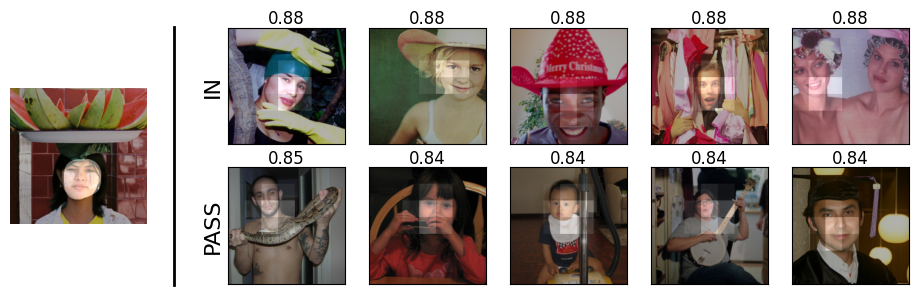

In [25]:
# visualize results
# set up the figure
DISPLAY_NUM = 5

fig = plt.figure(figsize=(11.6, 3.33), dpi=100)
gs = fig.add_gridspec(1,2, width_ratios=[1,5])
results_gs = gs[1].subgridspec(2,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_query_img, 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
ax.add_line(matplotlib.lines.Line2D([270,270], [-100,224+100], lw=2, color='black')).set_clip_on(False)

for i in range(DISPLAY_NUM):
  # handle ImageNet features
  idx = inet_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   x=inet_xs[idx],
                                   y=inet_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[0, i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel
  ax.set_title(f'{inet_sims[idx].cpu().numpy():.2f}', fontsize=12, pad=0)
  if i==0:
    ax.set_ylabel('IN', fontsize=16)

  # now do the same for PASS features
  idx = pass_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   x=pass_xs[idx],
                                   y=pass_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[1, i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title(f'{pass_sims[idx].cpu().numpy():.2f}', fontsize=12, pad=0)
  if i==0:
    ax.set_ylabel('PASS', fontsize=16)

If the face was selected as the query region (as in Fig. 7, row a), notice how both models' nearest neighbors are also other faces (despite the fact that the PASS-trained model never saw human faces during training).

## Conclusion
In this notebook, we highlight how to use our visual feature search tool to understand what are the nearest neighbors in activation space for a model. In particular, we highlight three use cases for our tool:
1. understanding how in- vs. **out-of-domain images** are represented by a model
2. comparing representations between fully-supervised and **self-supervised models**
3. analyzing the effect that the choice of the training dataset (specifically **PASS vs. ImageNet**) has on a model's feature representation.

In our full paper, we also show results from several quantitative experiments that paired with some of our qualitative visualizations as well as explored a fourth use case of our tool: to visualize how a representation has changed after a model has been edited. Please see our full paper for more details on those experiments and visualizations not shown in this notebook.

#### Limitations
The main limitation of our work is its qualitative nature: While our tool is useful for developing intuition about how a model works; any hypotheses should be substantiated with quantitative experiments.
We caution users from using our tool alone to confirm hypotheses and suggest that it be used as an exploratory tool in conjunction with other visualizations and experiments (as done in Secs. 4.3 and 4.4 in our full paper).

## Citations
For full citations and a complete set of references, please see our full paper.

* Asano et al., NeurIPS Datasets 2021. PASS: An ImageNet replacement for self-supervised pretraining without humans. [[link](https://www.robots.ox.ac.uk/~vgg/data/pass/)]
* Bau et al., SIGGRAPH 2019. Semantic photo manipulation with a generative image prior. [[link](https://ganpaint.io/)]
* Chen et al., ICML 2020. A Simple Framework for Contrastive Learning of Visual Representations. [[link](https://github.com/google-research/simclr)]
* Hendrycks et al., CVPR 2021. Natural adversarial examples. [[link](https://github.com/hendrycks/natural-adv-examples)]
* Wang et al., NeurIPS 2019. Learning robust global representations by penalizing local predictive power. [[link](https://github.com/HaohanWang/ImageNet-Sketch)]

## Acknowledgements

We are grateful for support from [Open Philanthropy](https://www.openphilanthropy.org/) (RF), the [Princeton Engineering Project X Fund](https://aspire-report.princeton.edu/engineering/project-x-fund) (RF), and [Princeton SEAS IW Funding](https://engineering.princeton.edu/undergraduate-studies/sophomore-senior-advising/senior-thesis-independent-work-funding) (DU).
We thank [David Bau](https://baulab.info/), [Sunnie S. Y. Kim](https://sunniesuhyoung.github.io/), and Indu Panigrahi for helpful discussions and/or feedback on our tool.
We also thank the authors of GANPaint ([Bau et al., SIGGRAPH 2019](https://ganpaint.io/)), whose [widget](https://github.com/CSAILVision/gandissect/blob/master/client/ganpaint.html) we based our highlighting widget on.